<a href="https://colab.research.google.com/github/AlirezaAbedinii/ImageCaptioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-jrbe1zov
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-jrbe1zov
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312215 sha256=dc5d88c57ea3788c781d8a2ede438d0e86f099b677b2fe6ebcd176aebe6481b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-9knixr85/wheels/6f/c9/51/e266f0496048c16686e133d8e33644d692931a356bfb372aae
Successfully built pycocoevalcap


In [2]:
!pip install --upgrade bleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5801 sha256=811d7dea62acfa9318b688bfc955972663ab647a7fd2211e475de6ab25f22588
  Stored in directory: /root/.cache/pip/wheels/90/95/f7/3b9dd43fae308b83b018fb3c1b8647d622b3401c23a7ebc41e
  Created wheel for efficiency: filename=efficiency-1.1-py3-none-any.whl size=22158 sha256=4f0cb435170467796d00ad05788bb8fff00962f3550f707002998f15694ce65d
  Stored in directory: /root/.cache/pip/wheels/eb/c2/8e/2bc261126dcc968d98baacf12e6af4108e78652c9e7c85ea7c
Successfully built bleu efficiency


# Imports

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import zipfile
from tensorflow.keras.applications.resnet50 import ResNet50
import re
import tqdm
import pickle
from bleu import list_bleu
from nltk.translate.bleu_score import sentence_bleu

In [4]:
from collections import defaultdict
import json
import time
import itertools
import os, os.path

In [5]:
%matplotlib inline 
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import random
from shutil import copyfile
import cv2
import time
from PIL import Image

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

In [7]:
from gym import Env
from gym import spaces

In [75]:
tref = ['a man climbing a mountain', 
 'a man climbs a mountain',
 'a man is climbing a side of a mountain',
 'a shirtless man climbs up a steep mountain',
 'a young white man is climbing a mountain with a rope as a guide']
 
hyp = 'a man climbs a cliff face'
sentence_bleu(tref, hyp) 

0.6342834010525136

# Globals

## Variables

In [9]:
dataDir='/content/drive/MyDrive/Dataset/annotations_trainval2017.zip (Unzipped Files)'
dataType='val2017'
pictures_dir_path = "/content/drive/MyDrive/Dataset/val2017.zip (Unzipped Files)/val2017"
train_dir_path = "/content/drive/MyDrive/Dataset/Train"
test_dir_path = "/content/drive/MyDrive/Dataset/Test"
global_images_ids = []
global_data = []
global_test_data = []
global_train_data = []
train_pics = []
test_pics = []
dataset = pd.DataFrame(columns = ['id', 'is_training' 'r', 'g', 'b',
                                  'captions', 'url'])
train_df_path = '/content/drive/MyDrive/Dataset/train_data.csv'
test_df_path = '/content/drive/MyDrive/Dataset/test_data.csv'

embedding_dim = 2048
max_length = 16
num_words = 2075
train_caps = {}

In [10]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=2.05s)
creating index...
index created!


## Classes

In [11]:
class Data:
  def __init__(self, id, captions):
    self.id = id
    self.captions = captions
    self.image = img_id_to_data(self.id)
  
  def show_info(self):
    show_img_by_file(pictures_dir_path + "/" + img_id_to_url(self.id))
    print(self.captions)
    

## Methods

In [12]:
def show_img_by_file(file_address):
  plt.imshow(mpimg.imread(file_address))
  plt.axis('off')
  plt.show()

def img_id_to_url(img_id, img_type='jpg'):
  str_id = str(img_id)

  return str_id.zfill(12) + '.' + img_type

def img_id_to_data(img_id, img_height=224, img_width=224):
  url = img_id_to_url(img_id)
  img_path = pictures_dir_path+'/'+url
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
  # img = mpimg.imread(pictures_dir_path+'/'+url)
  # img = Image.open(img_path).convert('RGB')

  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  
  # img /= 255.
  input_arr /= 255.
  
  return input_arr

def show_image_by_data(img):
  plt.imshow(img)
  plt.show()


# Dataset

## Train/Test Split

In [13]:
def split_data(source_dir, train_dir, test_dir, split_size):
  items = os.listdir(source_dir)
  items = random.sample(items, len(items))

  for i in range(len(items)):
    if i < split_size * len(items):
      copyfile(os.path.join(source_dir, items[i]), os.path.join(train_dir, items[i]))
    else:
      copyfile(os.path.join(source_dir, items[i]), os.path.join(test_dir, items[i]))

In [14]:
# Run the line below just for the first time
# split_data(pictures_dir_path, train_dir_path, test_dir_path, 0.8)
print(len(os.listdir(train_dir_path)), len(os.listdir(test_dir_path)))

4000 1000


## Load Images and Captions



In [15]:
def img_url_to_id(img_url, img_type='jpg'):
  return int(img_url[:-len(img_type)-1])

def load_img_captions(img_id):
  captions = []
  annIds = coco_caps.getAnnIds(imgIds=img_id);
  anns = coco_caps.loadAnns(annIds)
  for ann in anns:
    captions.append(ann['caption'])
  return captions

def load_imgs_and_caps(source_dir, is_training):
  global global_data, global_train_data, get_test_data
  images = os.listdir(source_dir)
  counter = 0
  # new
  total_ids = []
  total_is_trainings = []
  total_rs = []
  total_gs = []
  total_bs = []
  total_caps = []
  total_urls = []
  # new
  for img_url in images:
    # t1 = time.time()
    img_id = img_url_to_id(img_url)
    captions = load_img_captions(img_id)
    # data = Data(id = img_id, captions = captions)
    # new
    total_ids.append(img_id)
    total_is_trainings.append(is_training)

    t1 = time.time()
    img_data = img_id_to_data(img_id)

    # t2 = time.time()
    # print(f'1: {t2-t1}')

    total_rs.append(img_data) ###
    total_gs.append(img_data[1])
    total_bs.append(img_data[2])
    total_caps.append(captions)
    total_urls.append(img_url)
    
    t3 = time.time()
    # print(f'2: {t3-t2}')
    # new


    # global_data.append(data)
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
    # if is_training:
    #   global_train_data.append(data)
    #   train_pics.append(data.image)
    #   # train_pics.append(data)
    # else:
    #   global_test_data.append(data)
    #   test_pics.append(data.image)
    #   # test_pics.append(data)
    t3 = time.time()
    # print(f'2: {t3-t2}')
  return pd.DataFrame({
        "id": total_ids,
        "is_training": total_is_trainings,
        'r': total_rs,
        'g': total_gs,
        'b': total_bs,
        'captions': total_caps,
        'url': total_urls
    })

## Load and Save images to dataframes

In [16]:
"""
The code below load all images from the directories and save the required data
to dataframes (train, test), and then save it for the further usage.
"""
# train_df = load_imgs_and_caps(train_dir_path, True)
# print(len(global_train_data), len(global_test_data), len(global_data))
# test_df = load_imgs_and_caps(test_dir_path, False)
# print(len(global_train_data), len(global_test_data), len(global_data))
# train_df.to_csv("/content/drive/MyDrive/Dataset/train_data.csv", sep=',')
# test_df.to_csv('/content/drive/MyDrive/Dataset/test_data.csv', sep=',')

'\nThe code below load all images from the directories and save the required data\nto dataframes (train, test), and then save it for the further usage.\n'

## Read data from dataframes

In [17]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

### Delete extra rows

In [18]:
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])


### Get Image data

In [19]:
def string_to_array(raw_str, shape = [224,224]):

  edited = raw_str.replace('[', '')
  edited = edited.replace('\n','')
  edited = edited.replace(']', '')
  edited = re.sub(' +', ' ', edited)
  edited = np.fromstring(edited, dtype=float, sep=' ')
  return edited.reshape(shape)
  # print(edited)

In [20]:
# string_to_array(train_df['r'][0])
def all_data(ids):
  data = []
  counter = 0
  for id in ids:
    data.append(img_id_to_data(id))
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
  return data

## New way

In [21]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [22]:
# Load the inception v3 model
input1 = tf.keras.applications.InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
pt_model = tf.keras.models.Model(input1.input, input1.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = pt_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
"""
Run the code below for the first run
"""
# t_encoding = {}
# pre_path = '/content/drive/MyDrive/Dataset/Test/'
# for url in tqdm.tqdm(test_df['url']):
#     t_encoding[url] = encode(pre_path+url)

'\nRun the code below for the first run\n'

In [25]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open("/content/drive/MyDrive/test_images.pkl", "wb") as t_encoded_pickle:
#     pickle.dump(t_encoding, t_encoded_pickle)

'\nRun the code below for the first run\n'

In [26]:
t_features = pickle.load(open("/content/drive/MyDrive/test_images.pkl", "rb"))

### Train features

In [27]:
"""
Run the code below for the first run
"""
# encoding = {}
# pre_path = '/content/drive/MyDrive/Dataset/Train/'
# for url in tqdm.tqdm(train_df['url']):
#     encoding[url] = encode(pre_path+url)

'\nRun the code below for the first run\n'

In [28]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open("/content/drive/MyDrive/train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding, encoded_pickle)

'\nRun the code below for the first run\n'

In [29]:
# print(encoding['000000000139.jpg'])

### load features

In [30]:
features = pickle.load(open("/content/drive/MyDrive/images1.pkl", "rb"))

In [31]:
# testing
print(features['000000308587.jpg'])

[0.6432799  0.0756029  0.82783073 ... 0.64724636 0.11487135 0.03778623]


# Captions Processing

## Build Vocabularies

### Load captions (endseq)

In [32]:
def add_start_and_endseq(input_str):
  return 'startseq' + ' ' + input_str + ' ' + 'endseq'

#Load caption and add endseq at the end of them
def create_captions_dic(inp_coco_caps, dir_path = train_dir_path):
  captions_dic = {}
  images = os.listdir(dir_path)
  for img_url in images:
    img_id = img_url_to_id(img_url)
    annIds2 = inp_coco_caps.getAnnIds(imgIds=img_id)
    anns2 = inp_coco_caps.loadAnns(annIds2)
    counter = 0
    for ann in anns2:
      counter += 1
      # there are 13 images with 6 captions, not 5
      # if counter > 5:
      #   print (img_id)
      edited_caption = add_start_and_endseq(ann['caption'])
      if ann['image_id'] not in captions_dic:
        captions_dic[ann['image_id']] = [edited_caption]
      else:
        captions_dic[ann['image_id']].append(edited_caption)

  return captions_dic


In [33]:
train_caps = create_captions_dic(coco_caps)

#Test
print(train_caps[289516])

['startseq A clock sits above green bushes under a blue sky. endseq', 'startseq A clock on a stand displays the time in a garden. endseq', 'startseq A clock that is surrounded by tall grass in a park. endseq', 'startseq An old time looking clock surrounded by greenery.  endseq', 'startseq An old standing clock surrounded by tall grass. endseq', 'startseq A clock set to twenty after three in a field endseq']


In [34]:
test_caps = create_captions_dic(coco_caps, dir_path=test_dir_path)

#Test
print(len(test_caps))

1000


### Tokenization

#### Making a list of all captions

In [35]:
len(train_caps.values())
flat_train_caps = [cap for sublist in train_caps.values() for cap in sublist]

In [36]:
print(len(flat_train_caps))
print(len(train_caps.values()))

20013
4000


#### Tokenizing captions

In [37]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token='OOV', 
                      filters= "!'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n",
                      num_words=num_words)

# Generate the word index dictionary
tokenizer.fit_on_texts(flat_train_caps)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'OOV': 1, 'a': 2, 'startseq': 3, 'endseq': 4, 'on': 5, 'of': 6, 'the': 7, 'in': 8, 'with': 9, 'and': 10, 'is': 11, 'to': 12, 'man': 13, 'sitting': 14, 'two': 15, 'an': 16, 'standing': 17, 'at': 18, 'people': 19, 'next': 20, 'are': 21, 'white': 22, 'woman': 23, 'street': 24, 'table': 25, 'that': 26, 'it': 27, 'holding': 28, 'large': 29, 'person': 30, 'some': 31, 'tennis': 32, 'top': 33, 'group': 34, 'field': 35, 'train': 36, 'up': 37, 'down': 38, 'near': 39, 'black': 40, 'front': 41, 'plate': 42, 'cat': 43, 'small': 44, 'dog': 45, 'riding': 46, 'room': 47, 'playing': 48, 'young': 49, 'his': 50, 'red': 51, 'baseball': 52, 'by': 53, 'has': 54, 'water': 55, 'building': 56, 'walking': 57, 'sign': 58, 'bathroom': 59, 'side': 60, 'food': 61, 'while': 62, 'green': 63, 'pizza': 64, 'bus': 65, 'grass': 66, 'blue': 67, 'looking': 68, 'other': 69, 'there': 70, 'clock': 71, 'ball': 72, 'parked': 73, 'kitchen': 74, 'for': 75, 'game': 76, 'three': 77, 'city': 78, 'toilet': 79,

In [38]:
# Testing the tokenizer
tseq = tokenizer.texts_to_sequences(['Let us play some ball', 'asdlk ha sdjh askdjhasd hkajsd'])
print(tseq)
print(tseq[0][:2], tseq[0][2:])

[[1, 1718, 407, 31, 72], [1, 1, 1, 1, 1]]
[1, 1718] [407, 31, 72]


In [39]:
cap_lengths = [len(item.split(' ')) for item in flat_train_caps]
result = np.where(cap_lengths == np.amax(cap_lengths))
cap_lengths.sort(reverse = True)
len(cap_lengths)

20013

### Download Glove pretrained embedding

In [39]:
"""
only first time
"""
# !wget http://nlp.stanford.edu/data/glove.6B.zip

'\nonly first time\n'

In [40]:
"""
Only the first time
"""
# !unzip /content/glove.6B.zip -d /content/drive/MyDrive/Dataset/Glove/

'\nOnly the first time\n'

In [41]:
# tword, *tvector = 'Hey man SUP? wyd'.split()
# print(tword,tvector)

In [42]:
# def embedding_for_vocab(filepath, word_index,
#                         embedding_dim):
#   # num _words instead of word index length
#   vocab_size = num_words + 1
    
#   # Adding again 1 because of reserved 0 index
#   embedding_matrix_vocab = np.zeros((vocab_size,
#                                       embedding_dim))

#   with open(filepath, encoding="utf8") as f:
#     for line in f:
#       word, *vector = line.split()
#       # adding index if
#       if word in word_index and word_index[word] < num_words:
#         idx = word_index[word]
#         embedding_matrix_vocab[idx] = np.array(
#             vector, dtype=np.float32)[:embedding_dim]

#     return embedding_matrix_vocab
  

In [43]:
# embedding_matrix = embedding_for_vocab('/content/drive/MyDrive/Dataset/Glove/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [44]:
# print(len(embedding_matrix))

# Decoder

In [40]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      current_sequence = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(current_sequence)):
        input_sequences.append(current_sequence[0: i+1])
    ### END CODE HERE
    
    return input_sequences

In [41]:
def train_generator(tokenizer, captions, photos, batch_size):
  image_inp, sequence_inp, out_word = list(), list(), list()
  n=0
  # loop for ever over images
  while True:
      for img_id, caps_list in train_caps.items():
          n+=1
          # retrieve the photo feature
          photo = photos[img_id_to_url(img_id)]
          for cap in caps_list:
              # encode the sequence
              seq = tokenizer.texts_to_sequences([cap])[0]
              # print(seq)
              # return
              # seq = [tokenizer.word_index[word] for word in cap.split(' ') if word in tokenizer.word_index]
              
              # split one sequence into multiple X, y pairs
              for i in range(1, min(max_length+1, len(seq))):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=num_words)[0]
                  # store
                  image_inp.append(photo)
                  sequence_inp.append(in_seq)
                  out_word.append(out_seq)
                  
                  # print(in_seq, out_seq)

          # yield the batch data
          if n==batch_size:
            # print(image_inp[-1])
            yield ([np.array(image_inp), np.array(sequence_inp)], np.array(out_word))
            image_inp, sequence_inp, out_word = list(), list(), list()
            n=0

In [42]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(num_words, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)

decoder1 = add([fe2, se3])
# decoder1 = add([inputs1, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(num_words, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 2048)     4249600     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [43]:
tokenizer.word_counts['chrome']

4

In [50]:

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

epochs = 10
batch_size = 3
steps = len(train_caps)//batch_size

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
  print(f'Epoch {i+1}/{epochs}')
  generator = train_generator(tokenizer, train_caps, features, batch_size)
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V2' + '.h5')
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V3' + '.h5')
# model.save('/content/drive/MyDrive/Models/' + 'final_model_V4' + '.h5')
model.save('/content/drive/MyDrive/Models/' + 'final_model_V5' + '.h5')


Epoch 1/10
1333/1333 [==============================] - 153s 115ms/step - loss: 3.3686 - accuracy: 0.3715
Epoch 2/10
1333/1333 [==============================] - 152s 114ms/step - loss: 2.8501 - accuracy: 0.4101
Epoch 3/10
1333/1333 [==============================] - 152s 114ms/step - loss: 2.5867 - accuracy: 0.4346
Epoch 4/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.3865 - accuracy: 0.4560
Epoch 5/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.2162 - accuracy: 0.4774
Epoch 6/10
1333/1333 [==============================] - 151s 113ms/step - loss: 2.0637 - accuracy: 0.4997
Epoch 7/10
1333/1333 [==============================] - 148s 111ms/step - loss: 1.9290 - accuracy: 0.5215
Epoch 8/10
1333/1333 [==============================] - 148s 111ms/step - loss: 1.8150 - accuracy: 0.5418
Epoch 9/10
1333/1333 [==============================] - 151s 113ms/step - loss: 1.7185 - accuracy: 0.5605
Epoch 10/10
1333/1333 [=======================

In [51]:
# model.save('/content/drive/MyDrive/model_final' + '.h5')

# final_model = model

# Caption Generation

## Loading the MLE Model

In [60]:
final_model = tf.keras.models.load_model('/content/drive/MyDrive/Models/final_model_V4.h5')

In [61]:
# from tensorflow.python.ops.gen_array_ops import stop_gradient
def generate_caption(tokenizer, picture, max_length, model):
    generated_text = 'startseq'
    for i in range(max_length):
      split_generated_text = [generated_text]
      # print('0.', split_generated_text)

      sequence = tokenizer.texts_to_sequences(split_generated_text)

      # print('1.', sequence, sequence[0])
      # return 

      sequence = pad_sequences(sequence, maxlen=max_length)
      # sequence = np.array(sequence).flatten()
      # print('2.sequence: ', sequence)

      word_probs = model.predict([picture,sequence], verbose=0)
      
      # print('3.')

      # print(np.max(word_probs), np.min(word_probs))

      # dist = tfp.distributions.Categorical(probs=word_probs, dtype=tf.float32)
      # tf_predicted_index = dist.sample()
      # predicted_index = np.array(tf_predicted_index)
      predicted_index = [np.argmax(word_probs)]


      # print('4.', predicted_index)
      
      
      new_word = tokenizer.sequences_to_texts([predicted_index])[0]
      generated_text += ' ' + new_word
      # print('end', new_word)
      # return
      if new_word == 'endseq':
          break
    caption = generated_text.replace('startseq', '')
    caption = caption.replace(' endseq', '')
    # final = final[1:-1]
    # final = ' '.join(final)
    return caption

In [62]:
def compute_bleu(img_url, generated_caption):
  img_id = img_url_to_id(img_url)
  captions = test_caps[img_id]
  captions = [caption.replace('startseq ', '') for caption in captions]
  captions = [caption.replace(' endseq', '') for caption in captions]
  # print(captions)
  return sentence_bleu(captions, generated_caption)

# compute_bleu('000000336209.jpg', 'a shirtless man is skating on a steep')

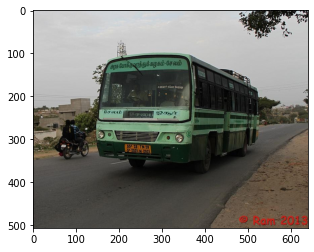

Caption:  a bus traveling on a street near a building
BLEU score: 0.7339350940968121


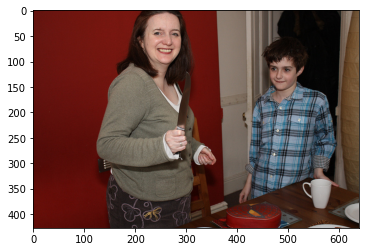

Caption:  a woman is holding a OOV in her hand
BLEU score: 0.6479888925811429


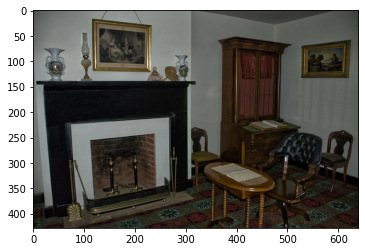

Caption:  a living room with a couch chair tv and a bookcase
BLEU score: 0.6484235528154839


In [63]:
def show_result(img_index, image_path = test_dir_path):
  pic = list(t_features.keys())[img_index]
  # print(pic[:-4])
  # return
  image = t_features[pic].reshape((1,2048))
  x = plt.imread(test_dir_path+ '/' + pic)
  plt.imshow(x)
  plt.show()
  caption = generate_caption(tokenizer, image, max_length, final_model)
  bleu_score = compute_bleu(pic, caption) 

  print("Caption:", caption)
  print("BLEU score:", bleu_score)

show_result(0)
show_result(10)
show_result(random.randint(0,1000))


# Reinforcement Learning

## Creating Environment

In [125]:
class ICEnv(Env):
  def __init__(self, image, img_id, max_len, num_words, startseq, endseq,
               tokenizer):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.max_len = max_len
    self.num_words = num_words
    self.startseq = startseq
    self.endseq = endseq
    self.done = False
    self.img_id = img_id
    self.tokenizer = tokenizer
    self.seq_len = 1

    self.observation_space = {'image': spaces.Box(low = 0, high = 255, 
                                                  shape=(2048,)),
                              "words": spaces.Box(low = 0, high = 2075, 
                                                  shape=(self.max_len,))}

    self.action_space = spaces.Discrete(self.num_words, start = 1)

    self.state = {'image': image, 
                  "words": np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))}


    

  def step(self, action):
    info = {}

    """ Might need to change """
    # Update previous reward
    self.prev_rewards.append(self.reward)

    # Apply action
    for i, word in enumerate(self.state['words']):
      if word == 0:
        self.state['words'][i] = action
        self.seq_len += 1
        break

    # Calculate reward
    ind_caption = []
    for word in self.state['words']:
        if word == self.endseq or word == 0:
          break
        elif word == self.startseq:
          continue
        else:
          ind_caption.append(word)

    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    references = train_caps[self.img_id]
    self.reward = sentence_bleu(references, caption)
    self.total_rewards += self.reward
    

    # Check if it's done
    if action == self.endseq or self.seq_len == self.max_len:
      self.done = True
    

    return self.state, self.reward, self.done, info

  
  def reset(self):
    self.prev_rewards = []
    self.reward = 0
    self.total_rewards = 0
    self.done = False
    self.seq_len = 1

    self.state["words"]= np.pad([self.startseq], (0, self.max_len -1),
                                  'constant' , constant_values=(0,0))

    return self.state

  def render(self, with_image = False):
    if with_image:
      img_path = pictures_dir_path + '/' + img_id_to_url(self.img_id)
      plt.imshow(plt.imread(img_path))
      plt.show()

    ind_caption = []
    for word in self.state['words']:
      if word == 0:
        break
      else:
        ind_caption.append(word)
    caption = tokenizer.sequences_to_texts([ind_caption])[0]
    print(caption)

In [126]:
tmp_img_id = list(train_caps.keys())[0]
tmp_img = features[img_id_to_url(tmp_img_id)]

env = ICEnv(image= tmp_img, img_id= tmp_img_id, 
            max_len=max_length, num_words=num_words,
            startseq = tokenizer.word_index['startseq'],
            endseq = tokenizer.word_index['endseq'], tokenizer= tokenizer)

In [127]:
env.action_space.sample()

700

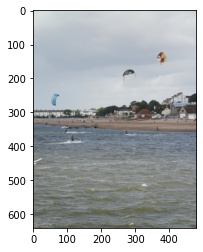

startseq
startseq
startseq farmer
startseq farmer calf
startseq farmer calf waves
startseq farmer calf waves volley
startseq farmer calf waves volley numerals
startseq farmer calf waves volley numerals shirt
startseq farmer calf waves volley numerals shirt tag
startseq farmer calf waves volley numerals shirt tag larger
startseq farmer calf waves volley numerals shirt tag larger kinds
startseq farmer calf waves volley numerals shirt tag larger kinds bank
startseq farmer calf waves volley numerals shirt tag larger kinds bank smoking
startseq farmer calf waves volley numerals shirt tag larger kinds bank smoking containing
startseq farmer calf waves volley numerals shirt tag larger kinds bank smoking containing saying
startseq farmer calf waves volley numerals shirt tag larger kinds bank smoking containing saying slopes
Episode:1 Score:2.457515300287006


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


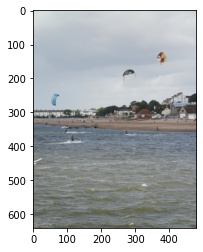

startseq
startseq
startseq pitch
startseq pitch mushrooms
startseq pitch mushrooms caught
startseq pitch mushrooms caught workers
startseq pitch mushrooms caught workers cleaned
startseq pitch mushrooms caught workers cleaned iron
startseq pitch mushrooms caught workers cleaned iron bags
startseq pitch mushrooms caught workers cleaned iron bags bamboo
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility paddle
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility paddle palm
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility paddle palm being
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility paddle palm being trays
startseq pitch mushrooms caught workers cleaned iron bags bamboo utility paddle palm being trays upon
Episode:2 Score:1.859325716759387


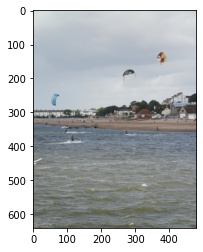

startseq
startseq
startseq display
startseq display fence
startseq display fence line
startseq display fence line tile
startseq display fence line tile looking
startseq display fence line tile looking fuzzy
startseq display fence line tile looking fuzzy cords
startseq display fence line tile looking fuzzy cords hall
startseq display fence line tile looking fuzzy cords hall lips
startseq display fence line tile looking fuzzy cords hall lips grazes
startseq display fence line tile looking fuzzy cords hall lips grazes boats
startseq display fence line tile looking fuzzy cords hall lips grazes boats pedestrians
startseq display fence line tile looking fuzzy cords hall lips grazes boats pedestrians these
startseq display fence line tile looking fuzzy cords hall lips grazes boats pedestrians these beverage
Episode:3 Score:2.031577516392453


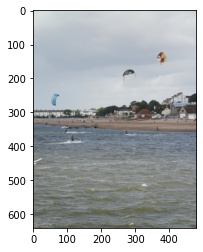

startseq
startseq
startseq there
startseq there sweater
startseq there sweater shore
startseq there sweater shore radio
startseq there sweater shore radio gaming
startseq there sweater shore radio gaming hole
startseq there sweater shore radio gaming hole medium
startseq there sweater shore radio gaming hole medium pipes
startseq there sweater shore radio gaming hole medium pipes volley
startseq there sweater shore radio gaming hole medium pipes volley photographer
startseq there sweater shore radio gaming hole medium pipes volley photographer spotted
startseq there sweater shore radio gaming hole medium pipes volley photographer spotted fashion
startseq there sweater shore radio gaming hole medium pipes volley photographer spotted fashion numerous
startseq there sweater shore radio gaming hole medium pipes volley photographer spotted fashion numerous garbage
Episode:4 Score:2.9822456197479505


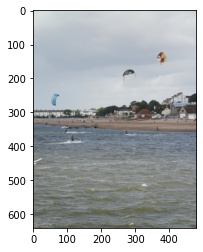

startseq
startseq
startseq garbage
startseq garbage district
startseq garbage district city
startseq garbage district city porch
startseq garbage district city porch being
startseq garbage district city porch being away
startseq garbage district city porch being away sides
startseq garbage district city porch being away sides include
startseq garbage district city porch being away sides include coffee
startseq garbage district city porch being away sides include coffee board
startseq garbage district city porch being away sides include coffee board trying
startseq garbage district city porch being away sides include coffee board trying freight
startseq garbage district city porch being away sides include coffee board trying freight fuzzy
startseq garbage district city porch being away sides include coffee board trying freight fuzzy semi
Episode:5 Score:2.1708031601649216


In [128]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    env.render(with_image = True)
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

# Test blocks

In [ ]:
# ta = []
# test = {'words': [3,2,1,4,5,0,0,0,0,6],
#         'a': 's'}
# for i, word in enumerate(test['words']):
#       if word == 0:
#         test['words'][i] = 9
#         break
      # if word == 4 or word == 0:
      #     break
      # elif word == 3:
      #   continue
      # else:
      #   ta.append(word)
# ta
# test
#####################
# tokenizer.sequences_to_texts([[1,2,3,4]])
#####################
# list(train_caps.keys())[0]
features.keys()
#####################
# tokenizer.word_index['startseq']
# tokenizer.word_index['endseq']